In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 6
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Stat"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| output: false
(a,B) = (0,100.0)

(0, 100.0)

In [3]:
using AdvancedMH
using Distributions
using MCMCChains
using ForwardDiff
using StructArrays
using LinearAlgebra
using LogDensityProblems
using LogDensityProblemsAD

# Define the components of a basic model.
struct LogTargetDensity_Logistic
    a::Float64
    B::Float64
    n::Int64
end

LogDensityProblems.logdensity(p::LogTargetDensity_Logistic, ξ) = -log(2π * p.B) - (ξ[1] - p.a)^2/(2 * p.B) + ξ[1] - p.n * log(1 + exp(ξ[1]))
LogDensityProblems.dimension(p::LogTargetDensity_Logistic) = 1
LogDensityProblems.capabilities(::Type{LogTargetDensity_Logistic}) = LogDensityProblems.LogDensityOrder{0}()

function MHSampler(n::Int64; discard_initial=30000)

    model_with_ad = LogDensityProblemsAD.ADgradient(Val(:ForwardDiff), LogTargetDensity_Logistic(a, B, n))

    spl = RWMH(MvNormal(zeros(1), I))

    chain = sample(model_with_ad, spl, 50000; chain_type=Chains, param_names=["ξ"])

    return chain
end

# ξ_vector = MHSampler(10000)
# plot(ξ_vector, title="Plot of \$\\xi\$ values", xlabel="Index", ylabel="ξ", legend=false, color="#78C2AD")

MHSampler (generic function with 1 method)

In [4]:
using DataFrames
using Plots

n_list = [10, 100, 1000, 10000]

elapsed_time_Metropolis = @elapsed begin
    chains = [MHSampler(n) for n in n_list]
end

autos = [DataFrame(autocor(chain, lags=1:100)) for chain in chains]

combined_df = vcat(autos..., source=:chain)

lag_columns = names(combined_df)[2:101]
lags = 1:100

p_Metropolis = plot(
    title = "Metropolis",
    xlabel = "Lag",
    ylabel = "Autocorrelation",
    legend = :topright,
    background_color = "#F0F1EB"
)

for (i, n) in zip(1:4, n_list)
    plot!(
        p_Metropolis,
        lags,
        Array(combined_df[i, lag_columns]),
        label = "n = $n",
        linewidth = 2
    )
end

Sampling:   0%|▎                                        |  ETA: 0:00:23

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [5]:
using Random
using StatsFuns

struct PolyaGammaPSWSampler{T <: Real} <: Sampleable{Univariate, Continuous}
    b::Int
    z::T
end

struct JStarPSWSampler{T <: Real} <: Sampleable{Univariate, Continuous}
    z::T
end

function Base.rand(rng::AbstractRNG, s::PolyaGammaPSWSampler)
    out = 0.0
    s_aux = JStarPSWSampler(s.z / 2)
    for _ in 1:s.b
        out += rand(rng, s_aux) / 4
    end
    return out
end

function Base.rand(rng::AbstractRNG, s::JStarPSWSampler)
    z = abs(s.z)
    t = 0.64
    μ = 1 / z
    k = π^2 / 8 + z^2 / 2
    p = (π / 2 / k) * exp(- k * t) 
    q = 2 * exp( - z) * cdf(InverseGaussian(μ, 1.0), t)
    while true
        # Simulate a candidate x
        u = rand(rng)
        v = rand(rng)
        if (u < p / (p + q))
            # (Truncated Exponential)
            e = randexp(rng)
            x = t + e / k
        else
            # (Truncated Inverse Gaussian)
            x = randtigauss(rng, z, t)
        end
        # Evaluate if the candidate should be accepted
        s = a_xnt(x, 0, t)
        y = v * s
        n = 0
        while true
            n += 1
            if (n % 2 == 1)
                s += a_xnt(x, n, t)
                y > s && break
            else
                s -= a_xnt(x, n, t)
                y < s && return x
            end
        end
    end
end

# Return ``a_n(x)`` for a given t, see [1], eqs. (12)-(13)
# Equations (12)-(13) in [1]
# Note: 
# This is a literal transcription from the article's formula
# except for the letter case
function a_xnt(x::Real, n::Int, t::Real)
    x ≤ t ? a_xnt_left(x, n, t) : a_xnt_right(x, n, t)
end

# Return ``a_n(x)^L`` for a given t
# Equation (12) in [1]
# Note: 
# This is a literal transcription from the article's formula
# except for the letter case
function a_xnt_left(x::Real, n::Int, t::Real)
    π * (n + 0.5) * (2 / π / x)^(3 / 2) * exp(- 2 * (n + 0.5)^2 / x)
end

# Return ``a_n(x)^R`` for a given t, see [1], eq. (13)
# Equation (13) in [1]
# Note: 
# This is a literal transcription from the article's formula
# except for the letter case
function a_xnt_right(x::Real, n::Int, t::Real)
    π * (n + 0.5) * exp(- (n + 0.5)^2 * π^2 * x / 2)
end

# Simulate from an IG(μ, 1) distribution
# Algorithms 2-3 in [1]'s supplementary material
# Note: 
# This is a literal transcription from the article's pseudo code
# except for the letter case
function randtigauss(rng::AbstractRNG, z::Real, t::Real)
    1 / z > t ? randtigauss_v1(rng, z, t) : randtigauss_v2(rng, z, t)
end

# Simulate from an IG(μ, 1) distribution, for μ := 1 / z > t;
# Algorithms 2 in [1]'s supplementary material
# Note:
# This is a literal transcription from the article's pseudo code
# except for the letter case and one little a detail: the 
# original condition  `x > R` must be replaced by `x > t`
function randtigauss_v1(rng::AbstractRNG, z::Real, t::Real)
    x = t + one(t)
    α = zero(t)
    while rand(rng) > α
        e = randexp(rng) # In [1]: E 
        é = randexp(rng) # In [1]: E'
        while e^2 > (2 * é / t)
            e = randexp(rng)
            é = randexp(rng)
        end
        x = t / (1 + t * e)^2 
        α = exp(- z^2 * x / 2)
    end
    return x
end

# Simulate from an IG(μ, 1) distribution, for μ := 1 / z ≤ t
# Algorithms 3 in [1]'s supplementary material
# Note: This is a literal transcription from the article's pseudo code
function randtigauss_v2(rng::AbstractRNG, z::Real, t::Real)
    x = t + one(t)
    μ = 1 / z
    while x > t 
        y = randn(rng)^2
        x = μ + μ^2 * y / 2 - μ * √(4 * μ * y + (μ * y)^2) / 2
        if rand(rng) > μ / (μ + x)
            x = μ^2 / x
        end
    end
    return x
end

randtigauss_v2 (generic function with 1 method)

In [6]:
# using PolyaGammaSamplers


function PGSampler(n::Int64; discard_initial=30000, iter_number=50000, initial_ξ=0.0, B=100)

    λ = 1 - n/2

    ξ_list = [initial_ξ]
    ω_list = []

    while length(ξ_list) < iter_number
        ξ = ξ_list[end]
        ω_sampler = PolyaGammaPSWSampler(n, ξ)
        ω_new = rand(ω_sampler)
        push!(ω_list, ω_new)
        ξ_sampler = Normal((ω_new + B^(-1))^(-1) * λ, (ω_new + B^(-1))^(-1))
        ξ_new = rand(ξ_sampler)
        push!(ξ_list, ξ_new)
    end

    return Chains(ξ_list[discard_initial+1:end])
end

function Distributions.mean(s::PolyaGammaPSWSampler)
    s.b * inv(2.0 * s.z) * tanh(s.z / 2.0)
end

function Distributions.var(s::PolyaGammaPSWSampler)
    s.b * inv(4 * s.z^3) * (sinh(s.z) - s.z) * (sech(s.z / 2)^2)
end

In [7]:
elapsed_time_PolyaGamma = @elapsed begin
    chains = [PGSampler(n) for n in n_list]
end
autos = [DataFrame(autocor(chain, lags=1:100)) for chain in chains]

combined_df = vcat(autos..., source=:chain)

lag_columns = names(combined_df)[2:101]
lags = 1:100

p_PolyaGamma = plot(
    title = "Pólya-Gamma",
    xlabel = "Lag",
    ylabel = "Autocorrelation",
    legend = (0.65, 0.35),
    background_color = "#F0F1EB"
)

for (i, n) in zip(1:4, n_list)
    plot!(
        p_PolyaGamma,
        lags,
        Array(combined_df[i, lag_columns]),
        label = "n = $n",
        linewidth = 2,
    )
end

In [8]:
println("Elapsed time: $elapsed_time_Metropolis seconds v.s. $elapsed_time_PolyaGamma seconds")

Elapsed time: 2.631349584 seconds v.s. 98.630861333 seconds


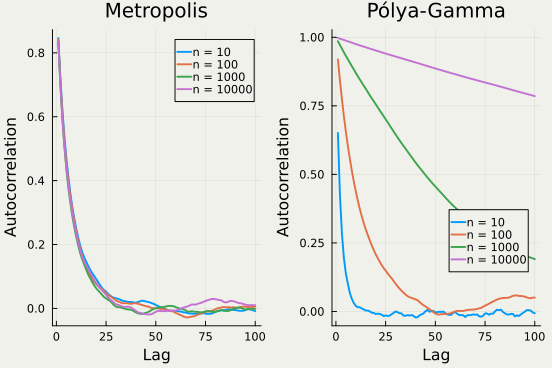

In [9]:
#| code-fold: true
plot(p_Metropolis, p_PolyaGamma, layout=(1,2), background_color = "#F0F1EB")